# 5. Advanced Gradient Descent Optimizers - AdaGrad, RMSProp and Adam

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (17/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### The problem with Vanilla GD

...

In [2]:
def obj_fun(val):
    a4 = 319/8400
    a3 = 43/4200
    a2 = -6799/8400
    a1 = -299/840
    a0 = 6
    return a4*val**4 + a3*val**3 + a2*val**2 + a1*val + a0

In [3]:
def obj_fun_deriv(val):
    a4 = 319/8400
    a3 = 43/4200
    a2 = -6799/8400
    a1 = -299/840
    return 4*a4*val**3 + 3*a3*val**2 + 2*a2*val + a1

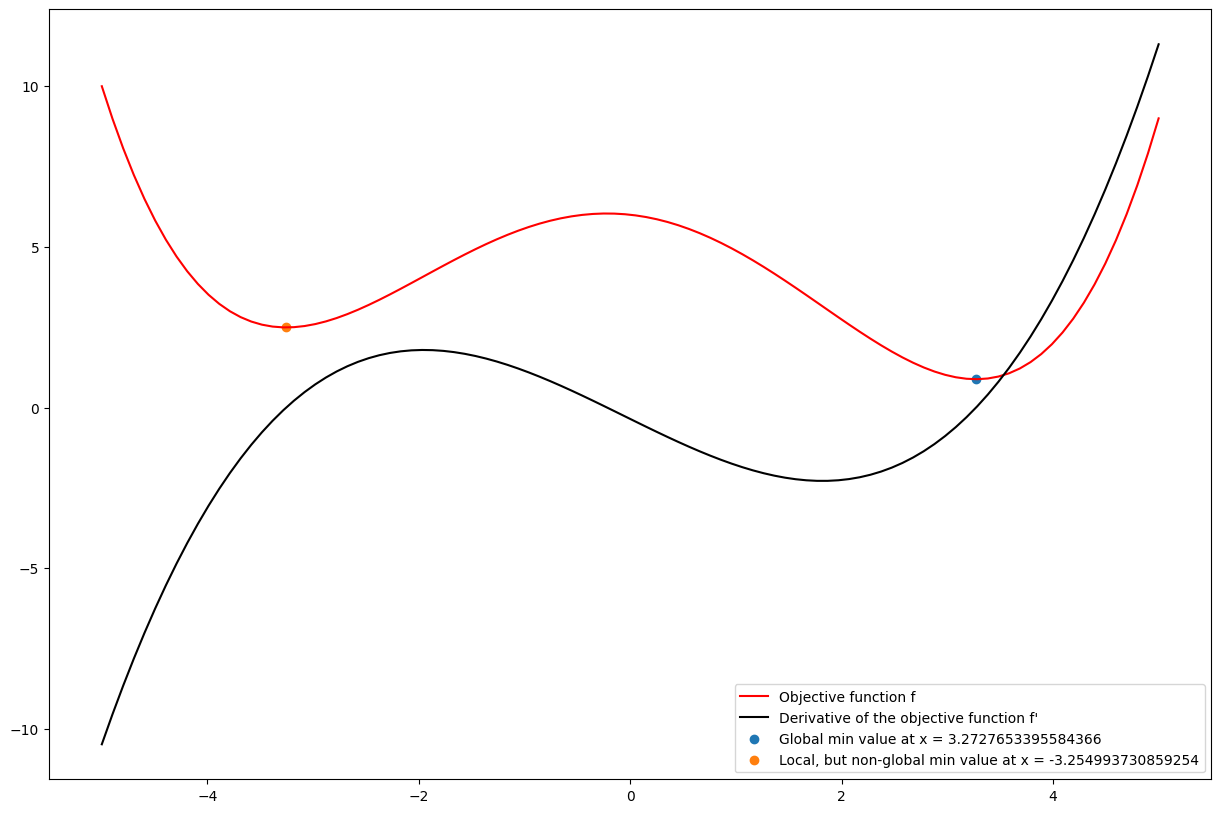

In [4]:
plt.figure(figsize = (15, 10))
x = np.linspace(-5, 5, 100)
y = [obj_fun(i) for i in x]
yp = [obj_fun_deriv(i) for i in x]
plt.plot(x, y, "r", label = "Objective function f")
plt.plot(x, yp, "k", label = "Derivative of the objective function f'")
approx_min_x = 3.2727653395584366
min_y = obj_fun(approx_min_x)
plt.scatter(approx_min_x, min_y, label = "Global min value at x = {}".format(approx_min_x))
approx_min_x2 = -3.254993730859254
min_y2 = obj_fun(approx_min_x2)
plt.scatter(approx_min_x2, min_y2, label = "Local, but non-global min value at x = {}".format(approx_min_x2))
plt.legend(loc = "best")
plt.show()

In [5]:
def vanilla_gd(start_val, alpha = 0.1, n_iter = 100):
    val = start_val
    list_vals = [val]
    for iter_num in range(n_iter):
        # Compute gradient and update value
        val -= alpha*obj_fun_deriv(val)
        list_vals.append(val)
    return val, list_vals

In [6]:
opt_val_vanilla_gd1, val_list_vanilla_gd1 = vanilla_gd(start_val = 5, alpha = 0.1, n_iter = 100)
print("Optimal, found by vanilla gd: ", opt_val_vanilla_gd1)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by vanilla gd:  3.2727653395584366
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


In [7]:
opt_val_vanilla_gd2, val_list_vanilla_gd2 = vanilla_gd(start_val = -5, alpha = 0.1, n_iter = 100)
print("Optimal, found by vanilla gd: ", opt_val_vanilla_gd2)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by vanilla gd:  -3.254993730859254
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


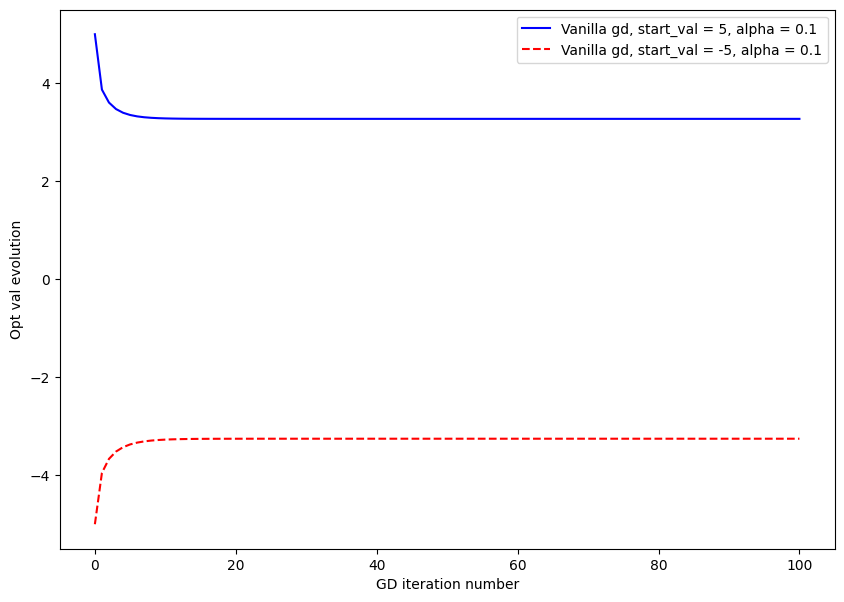

In [8]:
plt.figure(figsize = (10, 7))
plt.plot(range(len(val_list_vanilla_gd1)), val_list_vanilla_gd1, "b", label = "Vanilla gd, start_val = 5, alpha = 0.1")
plt.plot(range(len(val_list_vanilla_gd2)), val_list_vanilla_gd2, "r--", label = "Vanilla gd, start_val = -5, alpha = 0.1")
plt.xlabel("GD iteration number")
plt.ylabel("Opt val evolution")
plt.legend(loc = "best")
plt.show()

### Adding momentum to try and escape the local min

...

In [9]:
def momentum_gd(start_val, alpha = 0.1, mu = 0.1, n_iter = 100):
    val = start_val
    mom = 0
    list_vals = [val]
    for iter_num in range(n_iter):
        # Compute gradient and momentum
        grad = -alpha*obj_fun_deriv(val)
        mom = mu*mom + grad
        # Update value
        val += mom
        list_vals.append(val)
    return val, list_vals

In [10]:
opt_val_momentum_gd1, val_list_momentum_gd1 = momentum_gd(start_val = 5, alpha = 0.1, mu = 0.1, n_iter = 100)
print("Optimal, found by momentum gd: ", opt_val_momentum_gd1)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by momentum gd:  3.272765339558436
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


In [11]:
opt_val_momentum_gd2, val_list_momentum_gd2 = momentum_gd(start_val = -5, alpha = 0.1, mu = 0.1, n_iter = 100)
print("Optimal, found by momentum gd: ", opt_val_momentum_gd2)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by momentum gd:  -3.254993730859254
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


In [12]:
opt_val_momentum_gd3, val_list_momentum_gd3 = momentum_gd(start_val = -5, alpha = 0.1, mu = 0.9, n_iter = 100)
print("Optimal, found by momentum gd: ", opt_val_momentum_gd3)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by momentum gd:  3.267681061691328
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


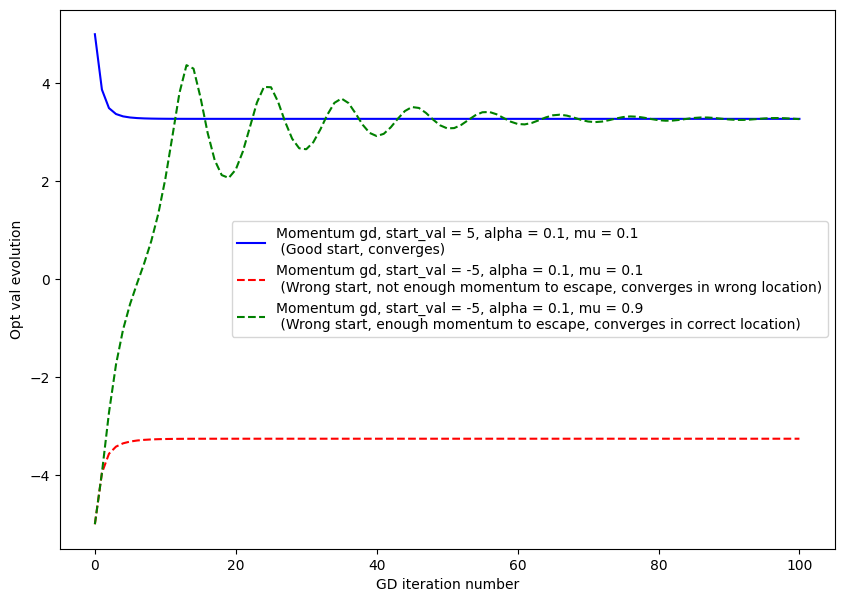

In [13]:
plt.figure(figsize = (10, 7))
label1 = "Momentum gd, start_val = 5, alpha = 0.1, mu = 0.1"
label1 += " \n (Good start, converges)"
plt.plot(range(len(val_list_momentum_gd1)), val_list_momentum_gd1, "b", label = label1)
label2 = "Momentum gd, start_val = -5, alpha = 0.1, mu = 0.1"
label2 += " \n (Wrong start, not enough momentum to escape, converges in wrong location)"
plt.plot(range(len(val_list_momentum_gd2)), val_list_momentum_gd2, "r--", label = label2)
label3 = "Momentum gd, start_val = -5, alpha = 0.1, mu = 0.9"
label3 += " \n (Wrong start, enough momentum to escape, converges in correct location)"
plt.plot(range(len(val_list_momentum_gd3)), val_list_momentum_gd3, "g--", label = label3)
plt.xlabel("GD iteration number")
plt.ylabel("Opt val evolution")
plt.legend(loc = "best")
plt.show()

### A variation on momentum, the Nesterov Accelerated Gradient (NAG)

Nesterov accelerated gradient descent (NAG) is a variant of stochastic gradient descent that can help accelerate convergence and improve the optimization of deep learning models. It does this by incorporating the concept of momentum, although in a slightly different way than before, which helps the optimization algorithm to continue moving in the same direction even if the gradients change.

In [14]:
def nesterov_gd(start_val, alpha = 0.1, mu = 0.1, n_iter = 100):
    val = start_val
    mom = 0
    list_vals = [val]
    for iter_num in range(n_iter):
        # Compute gradient and Nesterov momentum
        grad = -alpha*obj_fun_deriv(val)
        mom = mu*mom + grad
        # Update value
        val += mu*mom + grad
        list_vals.append(val)
    return val, list_vals

In [15]:
opt_val_nesterov_gd1, val_list_nesterov_gd1 = nesterov_gd(start_val = 5, alpha = 0.1, mu = 0.1, n_iter = 100)
print("Optimal, found by Nesterov gd: ", opt_val_nesterov_gd1)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Nesterov gd:  3.2727653395584366
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


In [16]:
opt_val_nesterov_gd2, val_list_nesterov_gd2 = nesterov_gd(start_val = -5, alpha = 0.1, mu = 0.1, n_iter = 100)
print("Optimal, found by Nesterov gd: ", opt_val_nesterov_gd2)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Nesterov gd:  -3.254993730859254
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


In [17]:
opt_val_nesterov_gd3, val_list_nesterov_gd3 = nesterov_gd(start_val = -5, alpha = 0.2, mu = 0.9, n_iter = 100)
print("Optimal, found by Nesterov gd: ", opt_val_nesterov_gd3)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Nesterov gd:  3.2727653395584357
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


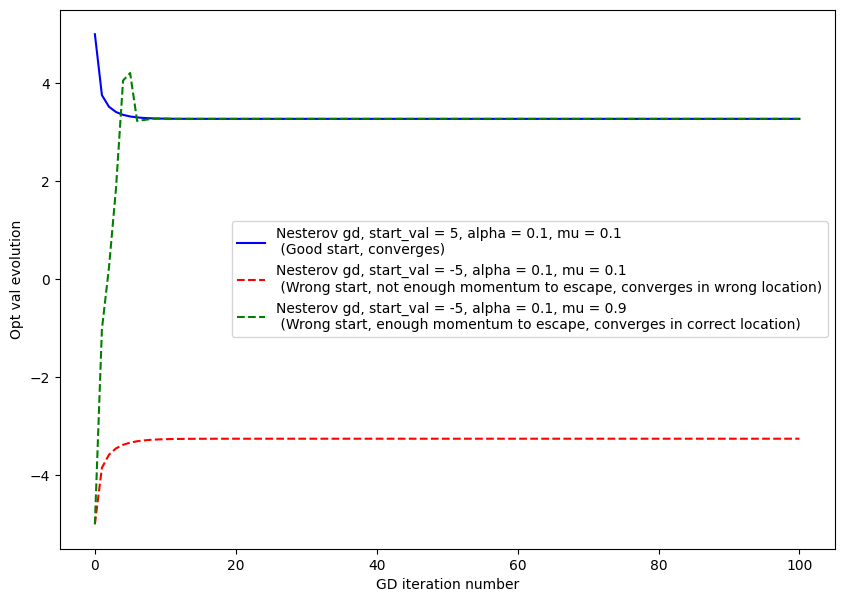

In [18]:
plt.figure(figsize = (10, 7))
label1 = "Nesterov gd, start_val = 5, alpha = 0.1, mu = 0.1"
label1 += " \n (Good start, converges)"
plt.plot(range(len(val_list_nesterov_gd1)), val_list_nesterov_gd1, "b", label = label1)
label2 = "Nesterov gd, start_val = -5, alpha = 0.1, mu = 0.1"
label2 += " \n (Wrong start, not enough momentum to escape, converges in wrong location)"
plt.plot(range(len(val_list_nesterov_gd1)), val_list_nesterov_gd2, "r--", label = label2)
label3 = "Nesterov gd, start_val = -5, alpha = 0.1, mu = 0.9"
label3 += " \n (Wrong start, enough momentum to escape, converges in correct location)"
plt.plot(range(len(val_list_nesterov_gd1)), val_list_nesterov_gd3, "g--", label = label3)
plt.xlabel("GD iteration number")
plt.ylabel("Opt val evolution")
plt.legend(loc = "best")
plt.show()

### Using a simple learning rate decay in Vanilla GD

...

In [19]:
def vanilla_gd_lrdecay(start_val, alpha = 0.1, alpha_decay_fac = 0.99, n_iter = 100):
    val = start_val
    list_vals = [val]
    for iter_num in range(n_iter):
        # Decay on LR
        alpha *= alpha_decay_fac
        # Update value
        val += -alpha*obj_fun_deriv(val)
        list_vals.append(val)
    return val, list_vals

In [20]:
opt_val_lrdecay_gd1, val_list_lrdecay_gd1 = vanilla_gd_lrdecay(start_val = 5, \
                                                              alpha = 0.2, \
                                                              alpha_decay_fac = 1, \
                                                              n_iter = 100)
print("Optimal, found by Vanilla LR decay gd: ", opt_val_lrdecay_gd1)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Vanilla LR decay gd:  3.272765339558436
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


In [21]:
opt_val_lrdecay_gd2, val_list_lrdecay_gd2 = vanilla_gd_lrdecay(start_val = 5, \
                                                               alpha = 0.2, \
                                                               alpha_decay_fac = 0.75, \
                                                               n_iter = 100)
print("Optimal, found by Vanilla LR decay gd: ", opt_val_lrdecay_gd2)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Vanilla LR decay gd:  3.2779747340306966
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


In [22]:
opt_val_lrdecay_gd3, val_list_lrdecay_gd3 = vanilla_gd_lrdecay(start_val = 5, \
                                                               alpha = 0.2, \
                                                               alpha_decay_fac = 0.5, \
                                                               n_iter = 100)
print("Optimal, found by Vanilla LR decay gd: ", opt_val_lrdecay_gd3)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Vanilla LR decay gd:  3.6473725891985467
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


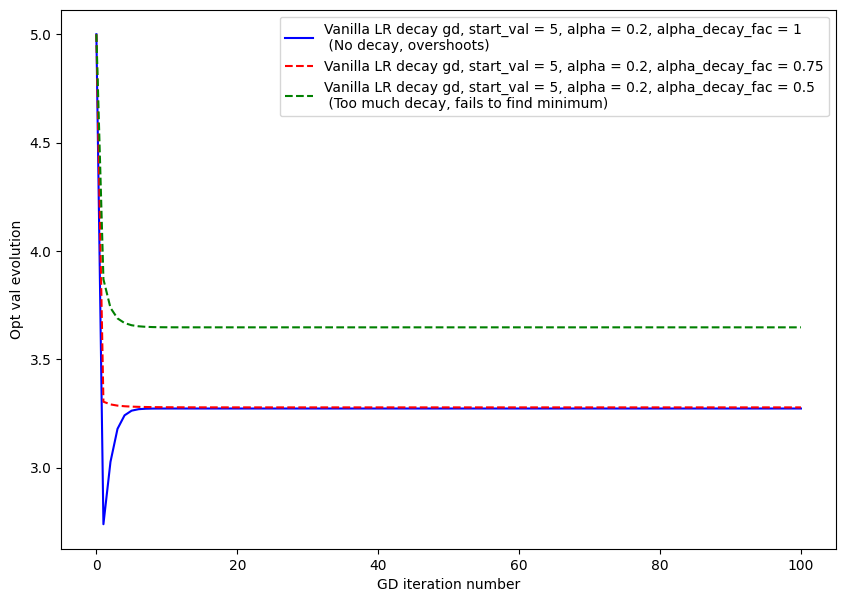

In [23]:
plt.figure(figsize = (10, 7))
label1 = "Vanilla LR decay gd, start_val = 5, alpha = 0.2, alpha_decay_fac = 1"
label1 += " \n (No decay, overshoots)"
plt.plot(range(len(val_list_lrdecay_gd1)), val_list_lrdecay_gd1, "b", label = label1)
label2 = "Vanilla LR decay gd, start_val = 5, alpha = 0.2, alpha_decay_fac = 0.75"
label1 += " \n (Optimal decay?)"
plt.plot(range(len(val_list_lrdecay_gd2)), val_list_lrdecay_gd2, "r--", label = label2)
label3 = "Vanilla LR decay gd, start_val = 5, alpha = 0.2, alpha_decay_fac = 0.5"
label3 += " \n (Too much decay, fails to find minimum)"
plt.plot(range(len(val_list_lrdecay_gd3)), val_list_lrdecay_gd3, "g--", label = label3)
plt.xlabel("GD iteration number")
plt.ylabel("Opt val evolution")
plt.legend(loc = "best")
plt.show()

### Dome additional examples of decay functions

Many other functions can be used to produce a decay on the learning rate. Below are a few notable examples.

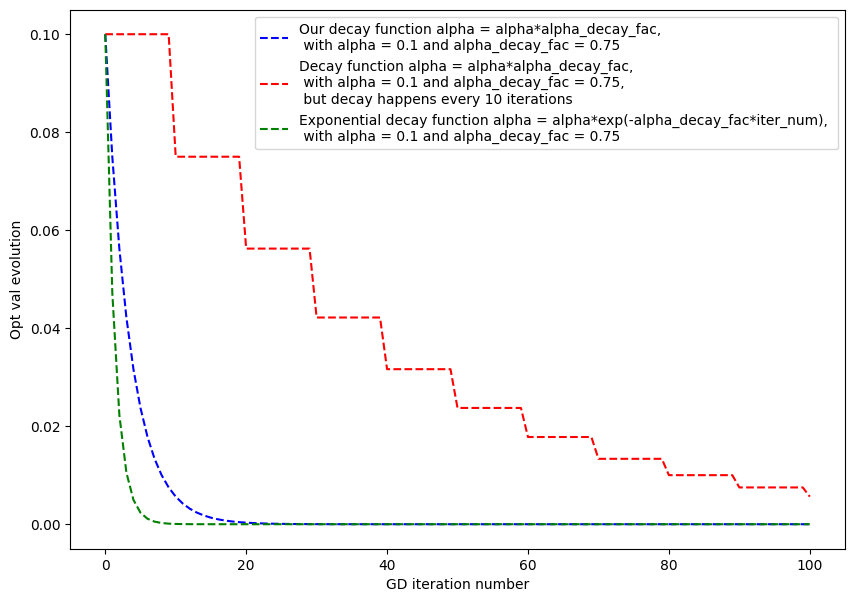

In [24]:
plt.figure(figsize = (10, 7))
label1 = "Our decay function alpha = alpha*alpha_decay_fac,"
label1 += " \n with alpha = 0.1 and alpha_decay_fac = 0.75"
plt.plot(range(101), [0.1*(0.75)**i for i in range(101)], "b--", label = label1)
label2 = "Decay function alpha = alpha*alpha_decay_fac,"
label2 += " \n with alpha = 0.1 and alpha_decay_fac = 0.75,"
label2 += " \n but decay happens every 10 iterations"
plt.plot(range(101), [0.1*(0.75)**(i//10) for i in range(101)], "r--", label = label2)
label3 = "Exponential decay function alpha = alpha*exp(-alpha_decay_fac*iter_num),"
label3 += " \n with alpha = 0.1 and alpha_decay_fac = 0.75"
plt.plot(range(101), [0.1*np.exp(-0.75*i) for i in range(101)], "g--", label = label3)
plt.xlabel("GD iteration number")
plt.ylabel("Opt val evolution")
plt.legend(loc = "best")
plt.show()

### Using a gradient-based learning rate decay in Vanilla GD

...

In [25]:
def vanilla_gd_gradlrdecay(start_val, alpha = 0.1, alpha_decay_fac = 0.99, n_iter = 100):
    val = start_val
    list_vals = [val]
    for iter_num in range(n_iter):
        # Compute gradients
        grad = obj_fun_deriv(val)
        # Gradient-based decay on LR
        alpha *= 1/(1 + alpha_decay_fac*np.sqrt(np.abs(grad)))
        # Update value
        val += -alpha*grad
        list_vals.append(val)
    return val, list_vals

In [26]:
opt_val_gradlrdecay_gd1, val_list_gradlrdecay_gd1 = vanilla_gd_gradlrdecay(start_val = 5, \
                                                                           alpha = 0.2, \
                                                                           alpha_decay_fac = 0.1, \
                                                                           n_iter = 100)
print("Optimal, found by Vanilla LR grad-decay gd: ", opt_val_gradlrdecay_gd1)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Vanilla LR grad-decay gd:  3.272765339558436
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


In [27]:
opt_val_gradlrdecay_gd2, val_list_gradlrdecay_gd2 = vanilla_gd_gradlrdecay(start_val = 5, \
                                                                           alpha = 0.2, \
                                                                           alpha_decay_fac = 0, \
                                                                           n_iter = 100)
print("Optimal, found by Vanilla LR grad-decay gd: ", opt_val_gradlrdecay_gd2)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Vanilla LR grad-decay gd:  3.272765339558436
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


In [28]:
opt_val_gradlrdecay_gd3, val_list_gradlrdecay_gd3 = vanilla_gd_gradlrdecay(start_val = 5, \
                                                                           alpha = 0.2, \
                                                                           alpha_decay_fac = 0.05, \
                                                                           n_iter = 100)
print("Optimal, found by Vanilla LR grad-decay gd: ", opt_val_gradlrdecay_gd3)
print("Global min: ", approx_min_x)
print("Local, non-global min: ", approx_min_x2)

Optimal, found by Vanilla LR grad-decay gd:  3.272765339558436
Global min:  3.2727653395584366
Local, non-global min:  -3.254993730859254


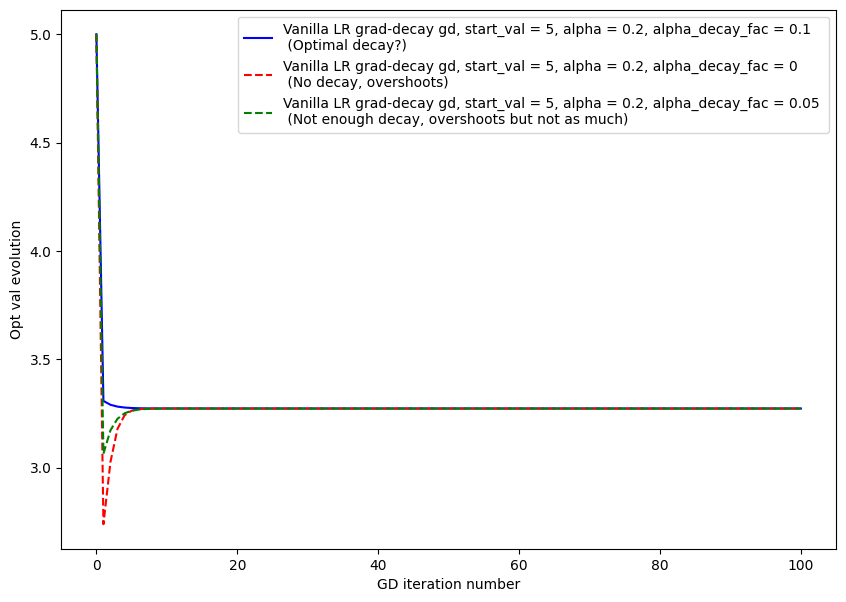

In [29]:
plt.figure(figsize = (10, 7))
label1 = "Vanilla LR grad-decay gd, start_val = 5, alpha = 0.2, alpha_decay_fac = 0.1"
label1 += " \n (Optimal decay?)"
plt.plot(range(len(val_list_gradlrdecay_gd1)), val_list_gradlrdecay_gd1, "b", label = label1)
label2 = "Vanilla LR grad-decay gd, start_val = 5, alpha = 0.2, alpha_decay_fac = 0"
label2 += " \n (No decay, overshoots)"
plt.plot(range(len(val_list_gradlrdecay_gd2)), val_list_gradlrdecay_gd2, "r--", label = label2)
label3 = "Vanilla LR grad-decay gd, start_val = 5, alpha = 0.2, alpha_decay_fac = 0.05"
label3 += " \n (Not enough decay, overshoots but not as much)"
plt.plot(range(len(val_list_gradlrdecay_gd3)), val_list_gradlrdecay_gd3, "g--", label = label3)
plt.xlabel("GD iteration number")
plt.ylabel("Opt val evolution")
plt.legend(loc = "best")
plt.show()

### Mock dataset, with nonlinearity

As in the previous notebook.

In [30]:
# All helper functions
eps = 1e-5
min_val = -1 + eps
max_val = 1 - eps
def val(min_val, max_val):
    return round(np.random.uniform(min_val, max_val), 2)
def class_for_val(val1, val2):
    k = np.pi
    return int(val2 >= -1/4 + 3/4*np.sin(val1*k))
n_points = 1000
def create_dataset(n_points, min_val, max_val):
    val1_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    val2_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    inputs = np.array([[v1, v2] for v1, v2 in zip(val1_list, val2_list)])
    outputs = np.array([class_for_val(v1, v2) for v1, v2 in zip(val1_list, val2_list)]).reshape(n_points, 1)
    return val1_list, val2_list, inputs, outputs

In [31]:
# Generate dataset
np.random.seed(47)
val1_list, val2_list, inputs, outputs = create_dataset(n_points, min_val, max_val)
# Check a few entries of the dataset
print(val1_list.shape)
print(val2_list.shape)
print(inputs.shape)
print(outputs.shape)
print(inputs[0:10, :])
print(outputs[0:10])

(1000,)
(1000,)
(1000, 2)
(1000, 1)
[[-0.77 -0.6 ]
 [ 0.95  0.28]
 [ 0.46 -0.91]
 [-0.3   0.23]
 [ 0.42 -0.61]
 [ 0.6   0.97]
 [ 0.29  0.37]
 [-0.17  0.4 ]
 [ 0.41  0.29]
 [-0.51  0.02]]
[[1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]]


As expected and observed in the plots below, the dataset now longer exhibits linearity. In fact the function is no longer polynomial either due to the presence of a logarithmic function.

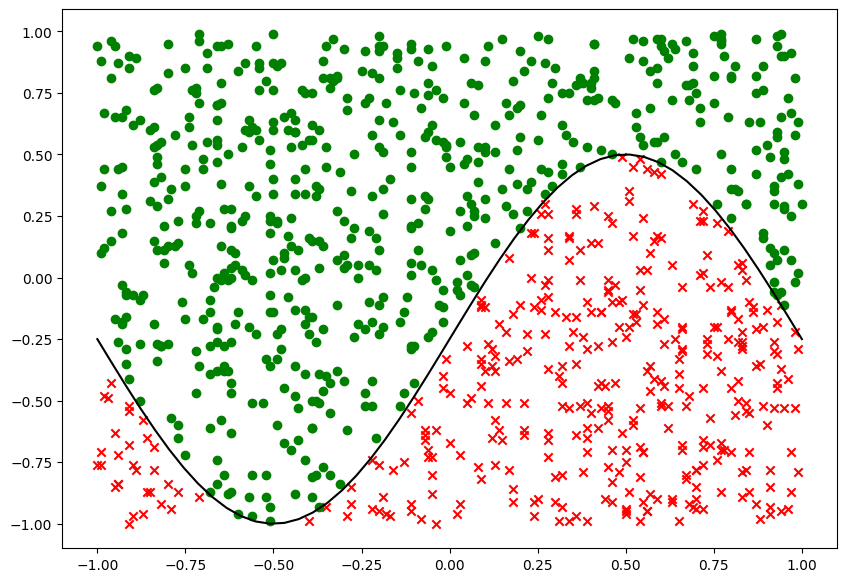

In [32]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])
    
# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary")

# Show
plt.show()

### Shallow Neural Net with Sigmoid Activations, Vanilla Gradient Descent in Backprop

As in the previous notebook.

In [33]:
class ShallowNeuralNet_VanillaGD():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
    
        # Compute error term
        epsilon = y_pred - outputs
        gradient_output = epsilon*y_pred*(1 - y_pred)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
        grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
        grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
        grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Gradient descent update rules
        self.W2 += alpha*grad_W2
        self.W1 += alpha*grad_W1
        self.b2 += alpha*grad_b2
        self.b1 += alpha*grad_b1
        
        # Update loss
        self.CE_loss(inputs, outputs)
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for beta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    print("Stopping early - loss evolution was less than delta on iteration {}.".format(iteration_number))
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

In [34]:
# Define and train neural network structure (Vanilla GD)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_vanilla = ShallowNeuralNet_VanillaGD(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_vanilla.train(inputs, outputs, N_max = 10000, alpha = 1, delta = 1e-10, display = True)
print(shallow_neural_net_vanilla.loss)

Iteration 1 - Loss = 0.67548314787971
Iteration 501 - Loss = 0.30685987533285164
Iteration 1001 - Loss = 0.28072737362278427
Iteration 1501 - Loss = 0.2767684596455835
Iteration 2001 - Loss = 0.27523233981483863
Iteration 2501 - Loss = 0.2738309958766424
Iteration 3001 - Loss = 0.2715794387758241
Iteration 3501 - Loss = 0.2670389214338261
Iteration 4001 - Loss = 0.2578281792849976
Iteration 4501 - Loss = 0.24428021177671885
Iteration 5001 - Loss = 0.22995639891920455
Iteration 5501 - Loss = 0.2169402657243242
Iteration 6001 - Loss = 0.20557271968108126
Iteration 6501 - Loss = 0.19561716511888258
Iteration 7001 - Loss = 0.18677868418612198
Iteration 7501 - Loss = 0.1788246612052226
Iteration 8001 - Loss = 0.17158920448704038
Iteration 8501 - Loss = 0.16495254967190284
Iteration 9001 - Loss = 0.15882146531175143
Iteration 9501 - Loss = 0.15311937397812175
Stopping - Maximal number of iterations reached.
0.14779497098873326


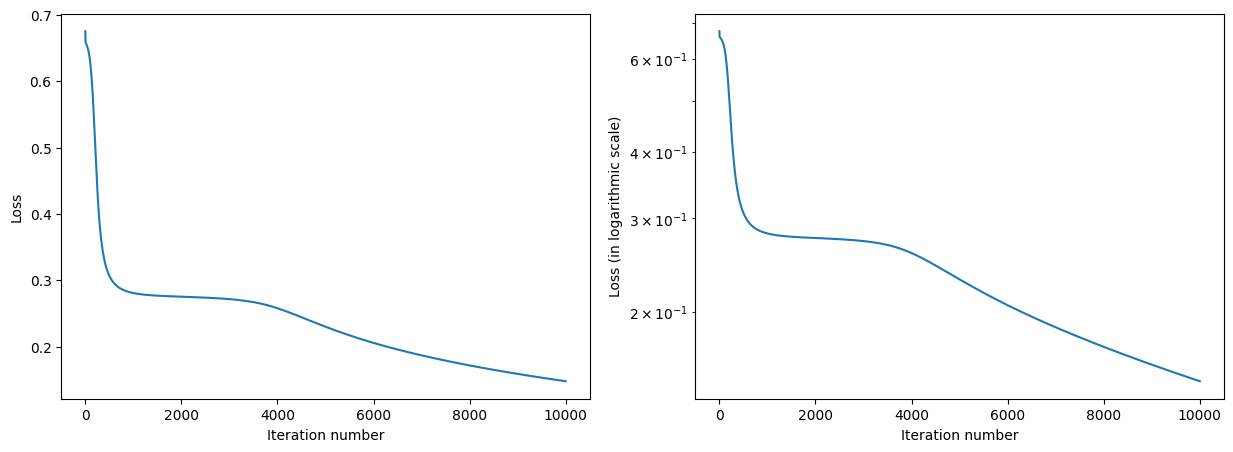

In [35]:
shallow_neural_net_vanilla.show_losses_over_training()

### Shallow Neural Net with Sigmoid Activations, AdaGrad in Backprop

AdaGrad: This variation of gradient descent adapts the learning rate for each parameter separately, based on the historical gradient information for that parameter. AdaGrad scales down the learning rate for parameters that have received a large number of updates, which can help prevent overfitting and improve the generalization ability of the model.

RMSProp: This variation of gradient descent is similar to AdaGrad, but it uses a running average of the squared gradients to scale the learning rate for each parameter, rather than using the sum of the squared gradients as in AdaGrad. RMSProp can be less sensitive to the learning rate than AdaGrad, and it is often used in conjunction with other techniques such as momentum.

Adam: This is a popular variation of gradient descent that combines the ideas of momentum and RMSProp. Adam uses an exponentially decaying average of the past gradients to scale the learning rate for each parameter, and it also uses an exponentially decaying average of the past squared gradients to scale the learning rate. Adam is widely used in deep learning applications because it can often achieve good performance with relatively little hyperparameter tuning.

In [36]:
class ShallowNeuralNet_AdaGrad():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, G_list, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
    
        # Compute error term
        epsilon = y_pred - outputs
        gradient_output = epsilon*y_pred*(1 - y_pred)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
        grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
        grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
        grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        G_W2, G_W1, G_b2, G_b1 = G_list
        G_W2 += grad_W2**2
        G_W1 += grad_W1**2
        G_b2 += grad_b2**2
        G_b1 += grad_b1**2
        G_list = [G_W2, G_W1, G_b2, G_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*grad_W2/(np.sqrt(G_W2 + eps))
        self.W1 += alpha*grad_W1/(np.sqrt(G_W1 + eps))
        self.b2 += alpha*grad_b2/(np.sqrt(G_b2 + eps))
        self.b1 += alpha*grad_b1/(np.sqrt(G_b1 + eps))
        
        # Update loss
        self.CE_loss(inputs, outputs)
        return G_list
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            G_list = self.backward(inputs, outputs, G_list, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for delta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    print("Stopping early - loss evolution was less than delta on iteration {}.".format(iteration_number))
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

In [37]:
# Define and train neural network structure (Adagrad)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_adagrad = ShallowNeuralNet_AdaGrad(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_adagrad.train(inputs, outputs, N_max = 10000, alpha = 1, delta = 1e-10, display = True)
print(shallow_neural_net_adagrad.loss)

Iteration 1 - Loss = 2.227378977390921
Iteration 501 - Loss = 0.04378998734992303
Iteration 1001 - Loss = 0.030435740199821367
Iteration 1501 - Loss = 0.02463453604972172
Iteration 2001 - Loss = 0.02124634890637233
Iteration 2501 - Loss = 0.018958628627755374
Iteration 3001 - Loss = 0.016830590557575773
Iteration 3501 - Loss = 0.014823809513736198
Iteration 4001 - Loss = 0.013413784320775533
Iteration 4501 - Loss = 0.012405904486446618
Iteration 5001 - Loss = 0.011623092147470385
Iteration 5501 - Loss = 0.010984729787501032
Iteration 6001 - Loss = 0.01044867607343477
Iteration 6501 - Loss = 0.009987261670353026
Iteration 7001 - Loss = 0.009580575851311472
Iteration 7501 - Loss = 0.009223609145344076
Iteration 8001 - Loss = 0.008899960099372762
Iteration 8501 - Loss = 0.008603374384775587
Iteration 9001 - Loss = 0.008327156160164932
Iteration 9501 - Loss = 0.008066433096447155
Stopping - Maximal number of iterations reached.
0.00781984246429852


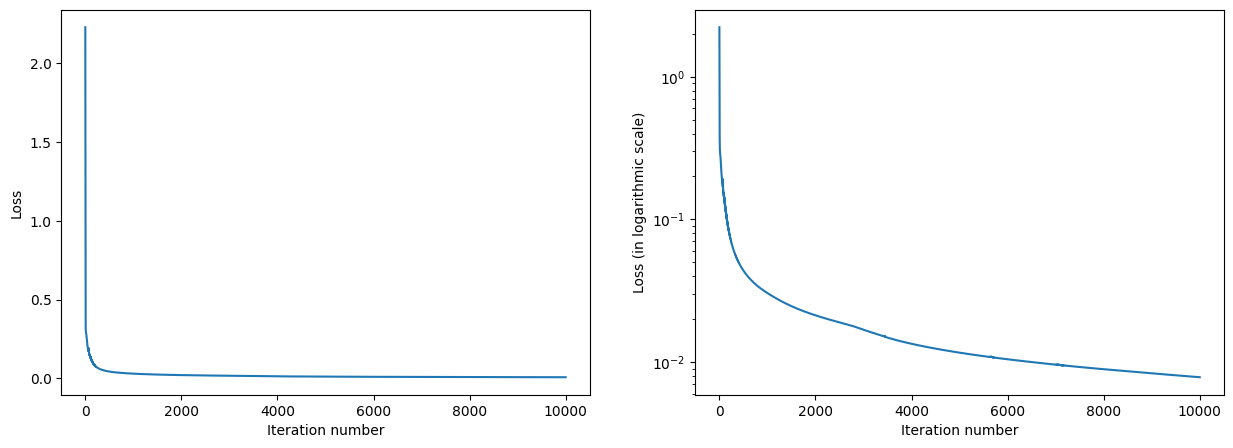

In [38]:
shallow_neural_net_adagrad.show_losses_over_training()

### Shallow Neural Net with Sigmoid Activations, RMSProp in Backprop

...

In [39]:
class ShallowNeuralNet_RMSProp():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, G_list, alpha = 1e-5, rho = 0.1):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
    
        # Compute error term
        epsilon = y_pred - outputs
        gradient_output = epsilon*y_pred*(1 - y_pred)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
        grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
        grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
        grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        G_W2, G_W1, G_b2, G_b1 = G_list
        G_W2 = rho*G_W2 + (1 - rho)*grad_W2**2
        G_W1 = rho*G_W1 + (1 - rho)*grad_W1**2
        G_b2 = rho*G_b2 + (1 - rho)*grad_b2**2
        G_b1 = rho*G_b1 + (1 - rho)*grad_b1**2
        G_list = [G_W2, G_W1, G_b2, G_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*grad_W2/(np.sqrt(G_W2 + eps))
        self.W1 += alpha*grad_W1/(np.sqrt(G_W1 + eps))
        self.b2 += alpha*grad_b2/(np.sqrt(G_b2 + eps))
        self.b1 += alpha*grad_b1/(np.sqrt(G_b1 + eps))
        
        # Update loss
        self.CE_loss(inputs, outputs)
        return G_list
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, rho = 0.1, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            G_list = self.backward(inputs, outputs, G_list, alpha, rho)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for delta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    print("Stopping early - loss evolution was less than delta on iteration {}.".format(iteration_number))
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

In [40]:
# Define and train neural network structure (RMSProp)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_rmsprop = ShallowNeuralNet_RMSProp(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_rmsprop.train(inputs, outputs, N_max = 10000, alpha = 1, rho = 0.1, delta = 1e-10, display = True)
print(shallow_neural_net_rmsprop.loss)

Iteration 1 - Loss = 2.34493800630799
Iteration 501 - Loss = 0.10141946191582756
Iteration 1001 - Loss = 0.07021431214238547
Iteration 1501 - Loss = 0.04745421414589225
Iteration 2001 - Loss = 0.04418588266747857
Iteration 2501 - Loss = 0.044948619140807285
Iteration 3001 - Loss = 0.0370088387367313
Iteration 3501 - Loss = 0.041889762525523525
Iteration 4001 - Loss = 0.04337890973062305
Iteration 4501 - Loss = 0.03202503905224395
Iteration 5001 - Loss = 0.02955232853618212
Iteration 5501 - Loss = 0.02754865675573487
Iteration 6001 - Loss = 0.026011819738442923
Iteration 6501 - Loss = 0.024748202054120212
Iteration 7001 - Loss = 0.023574985660539133
Iteration 7501 - Loss = 0.022016590517327673
Iteration 8001 - Loss = 0.019907471823703077
Iteration 8501 - Loss = 0.018528222309671927
Iteration 9001 - Loss = 0.01793873309584045
Iteration 9501 - Loss = 0.018049152525788453
Stopping - Maximal number of iterations reached.
0.02717920984606195


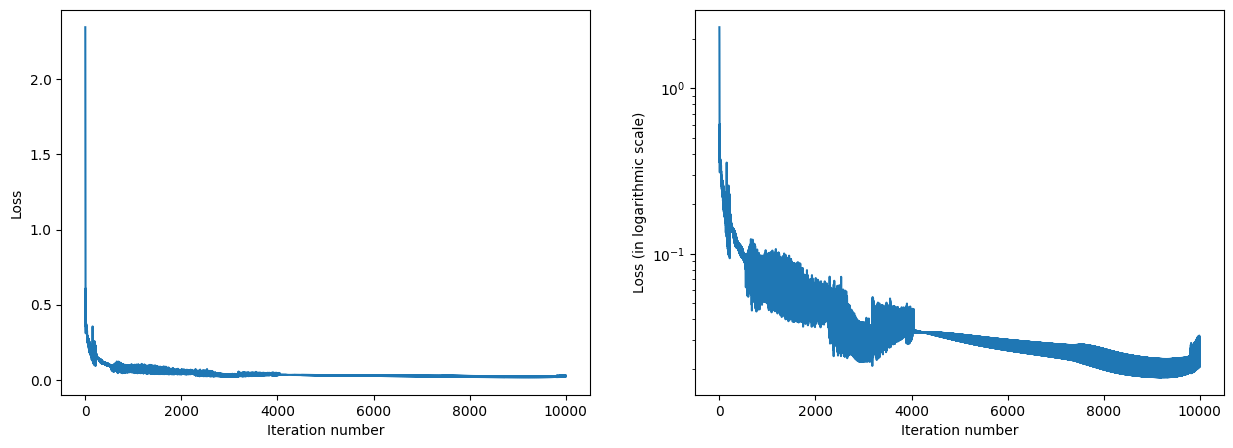

In [41]:
shallow_neural_net_rmsprop.show_losses_over_training()

### Shallow Neural Net with Sigmoid Activations, Adam in Backprop

...

In [42]:
class ShallowNeuralNet_Adam():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        self.loss = -np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, G_list, iteration_number, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
    
        # Compute error term
        epsilon = y_pred - outputs
        gradient_output = epsilon*y_pred*(1 - y_pred)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
        grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
        grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
        grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1 = G_list
        V_W2 = beta1*V_W2 + (1 - beta1)*grad_W2
        V_W1 = beta1*V_W1 + (1 - beta1)*grad_W1
        V_b2 = beta1*V_b2 + (1 - beta1)*grad_b2
        V_b1 = beta1*V_b1 + (1 - beta1)*grad_b1
        V_W2_norm = V_W2/(1 - beta1**iteration_number)
        V_W1_norm = V_W1/(1 - beta1**iteration_number)
        V_b2_norm = V_b2/(1 - beta1**iteration_number)
        V_b1_norm = V_b1/(1 - beta1**iteration_number)
        S_W2 = beta2*S_W2 + (1 - beta2)*grad_W2**2
        S_W1 = beta2*S_W1 + (1 - beta2)*grad_W1**2
        S_b2 = beta2*S_b2 + (1 - beta2)*grad_b2**2
        S_b1 = beta2*S_b1 + (1 - beta2)*grad_b1**2
        S_W2_norm = S_W2/(1 - beta2**iteration_number)
        S_W1_norm = S_W1/(1 - beta2**iteration_number)
        S_b2_norm = S_b2/(1 - beta2**iteration_number)
        S_b1_norm = S_b1/(1 - beta2**iteration_number)
        G_list = [V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*V_W2_norm/(np.sqrt(S_W2_norm) + eps)
        self.W1 += alpha*V_W1_norm/(np.sqrt(S_W1_norm) + eps)
        self.b2 += alpha*V_b2_norm/(np.sqrt(S_b2_norm) + eps)
        self.b1 += alpha*V_b1_norm/(np.sqrt(S_b1_norm) + eps)
        
        # Update loss
        self.CE_loss(inputs, outputs)
        return G_list
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1, \
                  0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            G_list = self.backward(inputs, outputs, G_list, iteration_number, alpha, beta1, beta2)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for delta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    print("Stopping early - loss evolution was less than delta on iteration {}.".format(iteration_number))
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

In [43]:
# Define and train neural network structure (Adam)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_adam = ShallowNeuralNet_Adam(n_x, n_h, n_y)
# Train and show final loss
shallow_neural_net_adam.train(inputs, outputs, N_max = 10000, alpha = 1e-1, beta1 = 0.9, \
                              beta2 = 0.999, delta = 1e-10, display = True)
print(shallow_neural_net_adam.loss)

Iteration 1 - Loss = 0.6561840401736492
Iteration 501 - Loss = 0.028117073418567944
Iteration 1001 - Loss = 0.014523173680372137
Iteration 1501 - Loss = 0.009527375327813161
Iteration 2001 - Loss = 0.006761285435984955
Iteration 2501 - Loss = 0.005001566583284715
Iteration 3001 - Loss = 0.003804680874974412
Iteration 3501 - Loss = 0.002954976773890774
Iteration 4001 - Loss = 0.0023425205345427545
Iteration 4501 - Loss = 0.0018888156622302405
Iteration 5001 - Loss = 0.0015436794381827274
Iteration 5501 - Loss = 0.0012745069060635852
Iteration 6001 - Loss = 0.001061612605660608
Iteration 6501 - Loss = 0.0008912301199444346
Iteration 7001 - Loss = 0.0007534056470510379
Iteration 7501 - Loss = 0.0006408751537735276
Iteration 8001 - Loss = 0.0005482682344243042
Iteration 8501 - Loss = 0.0004715524203546768
Iteration 9001 - Loss = 0.00040764996855182967
Iteration 9501 - Loss = 0.0003541743343329034
Stopping - Maximal number of iterations reached.
0.00030933051954046037


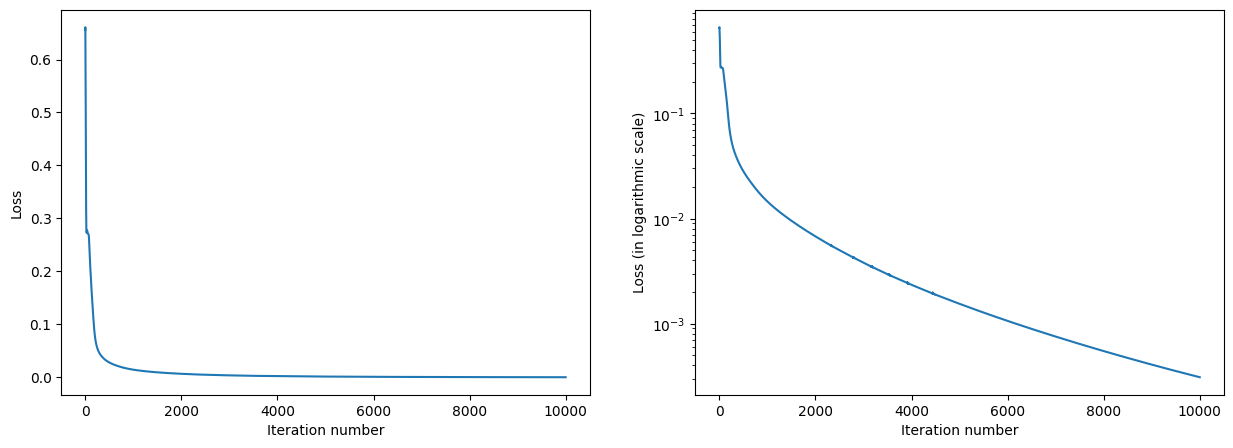

In [44]:
shallow_neural_net_adam.show_losses_over_training()

### Final visualizations and discussion

...

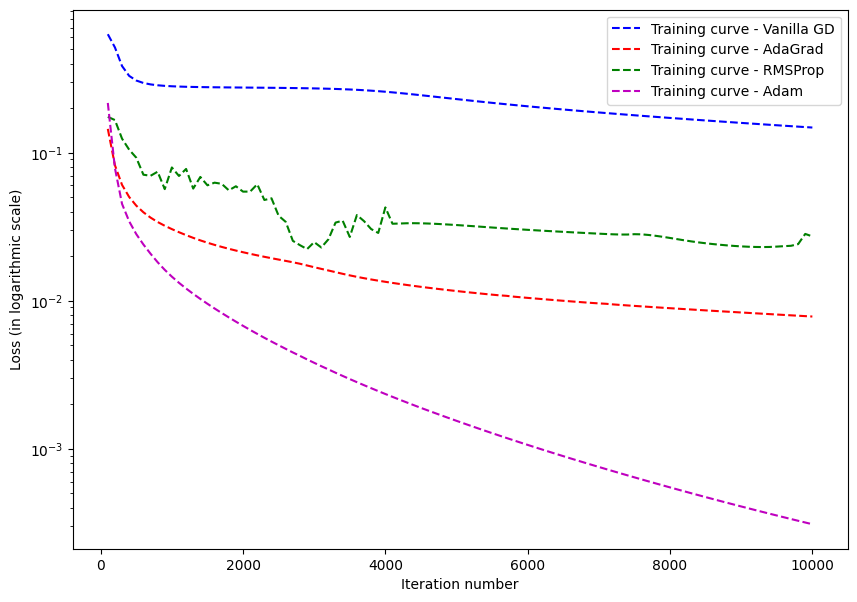

In [45]:
# Compare training curves
fig = plt.figure(figsize = (10, 7))
plt.plot(list(range(0, len(shallow_neural_net_vanilla.losses_list), 100)), \
         shallow_neural_net_vanilla.losses_list[::100], "b--", label = "Training curve - Vanilla GD")
plt.plot(list(range(0, len(shallow_neural_net_adagrad.losses_list), 100)), \
         shallow_neural_net_adagrad.losses_list[::100], "r--", label = "Training curve - AdaGrad")
plt.plot(list(range(0, len(shallow_neural_net_rmsprop.losses_list), 100)), \
         shallow_neural_net_rmsprop.losses_list[::100], "g--", label = "Training curve - RMSProp")
plt.plot(list(range(0, len(shallow_neural_net_adam.losses_list), 100)), \
         shallow_neural_net_adam.losses_list[::100], "m--", label = "Training curve - Adam")
plt.xlabel("Iteration number")
plt.ylabel("Loss (in logarithmic scale)")
plt.yscale("log")
plt.legend(loc = "best")
plt.show()

In [46]:
def find_v2(v1, model, min_val, max_val, thr = 1e-3):
    # Dichotomic search, to be used for boundary drawing later
    v2_min = min_val
    v2_max = max_val
    while((v2_max - v2_min) > thr):
        v2_avg = (v2_max + v2_min)/2
        out = model.forward([v1, v2_avg])
        if(out > 0.5):
            v2_max = v2_avg
        else:
            v2_min = v2_avg
    return (v2_max + v2_min)/2

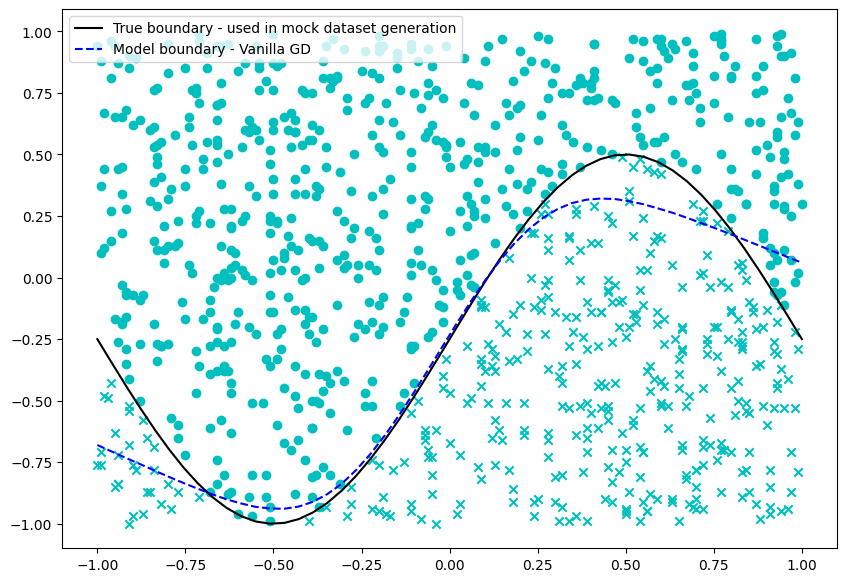

In [47]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - used in mock dataset generation")

# Display model boundary (sigmoid model, vanilla GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_vanilla = [find_v2(v1, shallow_neural_net_vanilla, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_vanilla, "b--", label = "Model boundary - Vanilla GD")

# Show
plt.legend(loc = "best")
plt.show()

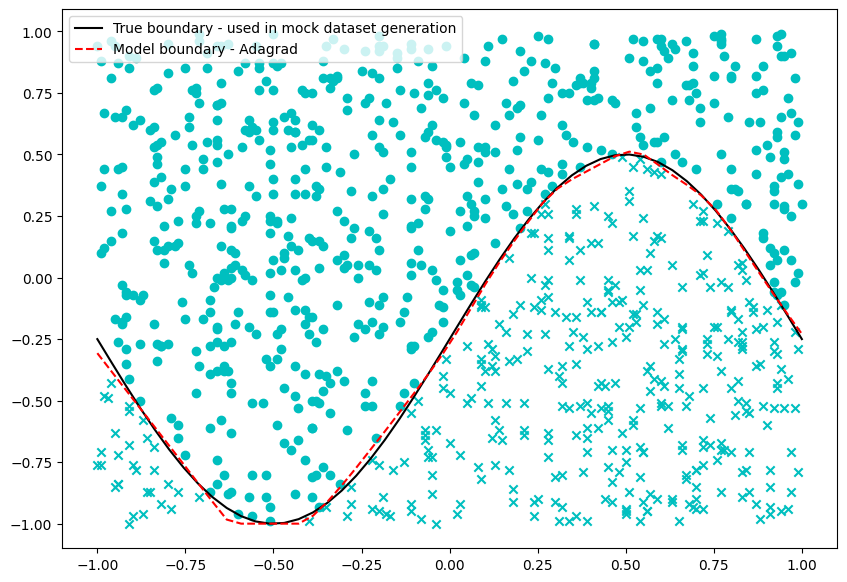

In [48]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - used in mock dataset generation")

# Display model boundary (sigmoid model, Adagrad GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_adagrad = [find_v2(v1, shallow_neural_net_adagrad, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_adagrad, "r--", label = "Model boundary - Adagrad")

# Show
plt.legend(loc = "best")
plt.show()

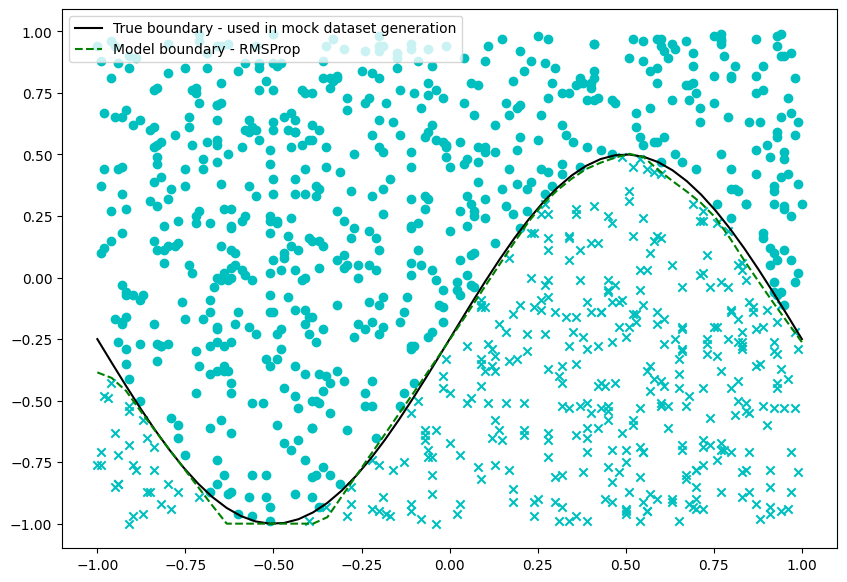

In [49]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - used in mock dataset generation")

# Display model boundary (sigmoid model, RMSProp GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_rmsprop = [find_v2(v1, shallow_neural_net_rmsprop, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_rmsprop, "g--", label = "Model boundary - RMSProp")

# Show
plt.legend(loc = "best")
plt.show()

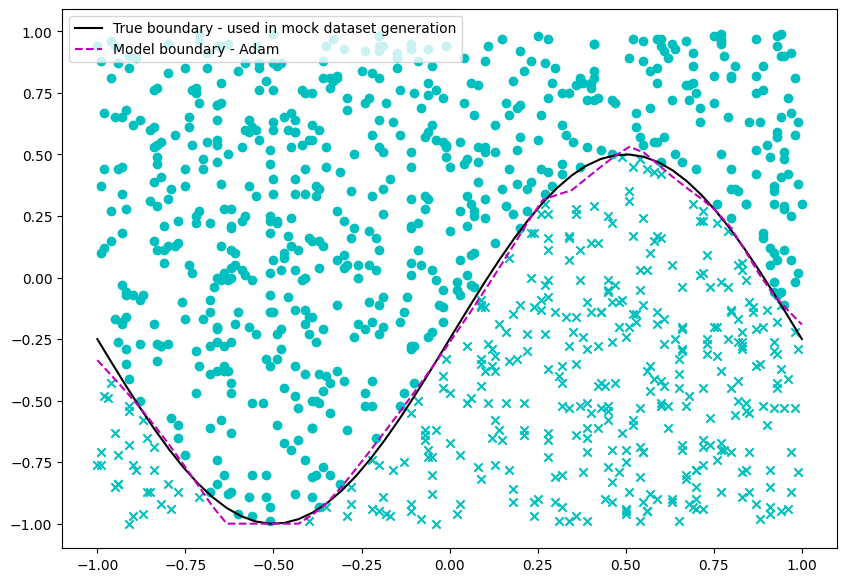

In [50]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - used in mock dataset generation")

# Display model boundary (sigmoid model, Adam GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_adam = [find_v2(v1, shallow_neural_net_adam, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_adam, "m--", label = "Model boundary - Adam")

# Show
plt.legend(loc = "best")
plt.show()

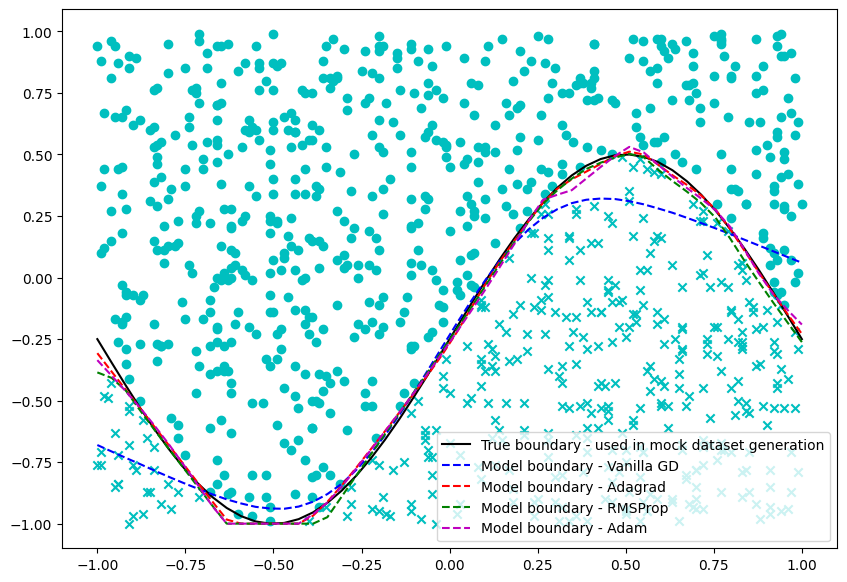

In [51]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - used in mock dataset generation")

# Display model boundary (sigmoid model, vanilla GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_vanilla = [find_v2(v1, shallow_neural_net_vanilla, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_vanilla, "b--", label = "Model boundary - Vanilla GD")

# Display model boundary (sigmoid model, Adagrad GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_adagrad = [find_v2(v1, shallow_neural_net_adagrad, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_adagrad, "r--", label = "Model boundary - Adagrad")

# Display model boundary (sigmoid model, RMSProp GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_rmsprop = [find_v2(v1, shallow_neural_net_rmsprop, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_rmsprop, "g--", label = "Model boundary - RMSProp")

# Display model boundary (sigmoid model, Adam GD)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_model_adam = [find_v2(v1, shallow_neural_net_adam, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_model_adam, "m--", label = "Model boundary - Adam")

# Show
plt.legend(loc = "best")
plt.show()

### What's next?

In the next notebook, we will investigate some additional variations on these optimizers, along with the mini-batch optimization procedure.